# Testing `Whirl2d` on Navier-Stokes solution with a body 

In [42]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body

In [43]:
Npts = 100
rad = 0.5
xcent = [0.0,0.0]
ang = 0.0
b = Bodies.Circle(Npts,rad,xcent,ang)

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]


### Create a domain with this body in it

In [44]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [45]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [46]:
Re = 200
physparams = NavierStokes.set_freestream([1.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)
tparams

Time step size 0.01

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [47]:
@time ops = NavierStokes.set_operators_body!(dom,params);

### Create an initial solution structure

In [48]:
s = NavierStokes.BodySoln(dom)

Solution: t = 0.0


### Advance the solution

In [49]:
@time for i = 1:100
    s = TimeMarching.ifherk!(s,tparams,ops)
end
s

6.573657 seconds (2.11 M allocations: 1.182 GiB, 3.02% gc time)
  

Solution: t = 1.0000000000000007


7.936967 seconds (1.32 M allocations: 2.114 GiB, 4.46% gc time)


In [50]:
ω, ψ, ux, uy = NavierStokes.evaluateFields(s.u,dom.grid)

([-5.86484e-17 -3.43606e-16 … 6.65231e-15 5.57879e-15; 6.37816e-17 -4.46978e-16 … 7.15338e-15 6.23367e-15; … ; -1.07724e-14 -1.17151e-14 … -1.24519e-14 -8.10777e-15; -1.23429e-14 -1.37417e-14 … -1.45668e-14 -9.25215e-15], [0.16341 0.16307 … -0.16307 -0.16341; 0.166684 0.166399 … -0.166399 -0.166684; … ; 0.0423383 0.0416754 … -0.0416754 -0.0423383; 0.0417989 0.0411419 … -0.0411419 -0.0417989], [-0.0170122 -0.0205926 … -0.0205926 -0.0170122; -0.014234 -0.0178403 … -0.0178403 -0.014234; … ; -0.0331477 -0.0336493 … -0.0336493 -0.0331477; -0.0328495 -0.0333394 … -0.0333394 -0.0328495], [-0.16368 -0.166458 … 0.166458 0.16368; -0.167101 -0.170064 … 0.170064 0.167101; … ; 0.0274728 0.0271724 … -0.0271724 -0.0274728; 0.026969 0.0266708 … -0.0266708 -0.026969])

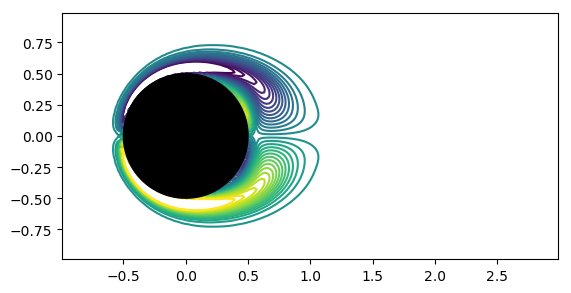

(-0.99, 2.99, -0.99, 0.99)

In [51]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)

contour(x,y,transpose(ω),linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

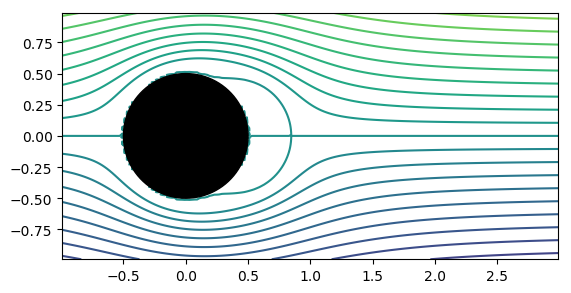

(-0.99, 2.99, -0.99, 0.99)

In [52]:
contour(x,y,transpose(ψ)+repmat(y,1,dom.grid.N[1]),linspace(-1.5,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")